In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from xgboost import plot_importance
import optuna
from sklearn.metrics import log_loss
from sklearn import preprocessing
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go

pd.set_option('display.max_columns', 501)
pd.set_option('display.max_rows', 501)

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# FUNCTIONS

In [2]:
# hyper-paremeter optimization
def optimize(n_optimization_trials, training_X, training_y, validation_X, validation_y):

    study = optuna.create_study()
    study.optimize(objective, n_trials=n_optimization_trials)
    print('Best params:')
    print(study.best_params)
    print('Log-loss for best params:')
    print(study.best_value)

In [3]:
def train_model(xgb_params, fit_params, training_X, training_y, validation_X, validation_y, testing_X, testing_y):

    # fit model
    model = XGBClassifier(objective='multi:softprob', **xgb_params)
    model.fit(training_X, training_y, eval_set=[(validation_X, validation_y)], **fit_params)

    # metrics
    predictions_validation = model.predict_proba(validation_X)
    logloss_validation = log_loss(validation_y, predictions_validation)
    print(f'Log-loss validation: {logloss_validation}')
    predictions_test = model.predict_proba(testing_X)
    logloss_test = log_loss(testing_y, predictions_test)
    print(f'Log-loss test: {logloss_test}')
    
    return model

# DATA

In [4]:
data = pd.read_csv('../../data/data_for_modelling.csv', index_col=0)
data

,season,name,position,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,General_#,General_Nation,General_Pos,General_Age,General_Min,Performance_Gls,Performance_Ast,Performance_PK,Performance_PKatt,Performance_Sh,Performance_SoT,Performance_CrdY,Performance_CrdR,Performance_Touches,Performance_Press,Performance_Tkl,Performance_Int,Performance_Blocks,Expected_xG,Expected_npxG,Expected_xA,SCA_SCA,SCA_GCA,Passes_Cmp,Passes_Att,Passes_Cmp%,Passes_Prog,Carries_Carries,Carries_Prog,Dribbles_Succ,Dribbles_Att,team,Total_Cmp,Total_Att,Total_Cmp%,Total_TotDist,Total_PrgDist,Short_Cmp,Short_Att,Short_Cmp%,Medium_Cmp,Medium_Att,Medium_Cmp%,Long_Cmp,Long_Att,Long_Cmp%,General_Ast,General_xA,General_KP,General_1/3,General_PPA,General_CrsPA,General_Prog,General_Att,Pass Types_Live,Pass Types_Dead,Pass Types_FK,Pass Types_TB,Pass Types_Press,Pass Types_Sw,Pass Types_Crs,Pass Types_CK,Corner Kicks_In,Corner Kicks_Out,Corner Kicks_Str,Height_Ground,Height_Low,Height_High,Body Parts_Left,Body Parts_Right,Body Parts_Head,Body Parts_TI,Body Parts_Other,Outcomes_Cmp,Outcomes_Off,Outcomes_Out,Outcomes_Int,Outcomes_Blocks,Tackles_Tkl,Tackles_TklW,Tackles_Def 3rd,Tackles_Mid 3rd,Tackles_Att 3rd,Vs Dribbles_Tkl,Vs Dribbles_Att,Vs Dribbles_Tkl%,Vs Dribbles_Past,Pressures_Press,Pressures_Succ,Pressures_%,Pressures_Def 3rd,Pressures_Mid 3rd,Pressures_Att 3rd,Blocks_Blocks,Blocks_Sh,Blocks_ShSv,Blocks_Pass,General_Int,General_Tkl+Int,General_Clr,General_Err,Touches_Touches,Touches_Def Pen,Touches_Def 3rd,Touches_Mid 3rd,Touches_Att 3rd,Touches_Att Pen,Touches_Live,Dribbles_Succ%,Dribbles_#Pl,Dribbles_Megs,Carries_TotDist,Carries_PrgDist,Carries_1/3,Carries_CPA,Carries_Mis,Carries_Dis,Receiving_Targ,Receiving_Rec,Receiving_Rec%,Receiving_Prog,Performance_2CrdY,Performance_Fls,Performance_Fld,Performance_Off,Performance_Crs,Performance_TklW,Performance_PKwon,Performance_PKcon,Performance_OG,Performance_Recov,Aerial Duels_Won,Aerial Duels_Lost,Aerial Duels_Won%,fpl_position_GK,fpl_position_DEF,fpl_position_MID,fpl_position_FWD,fbref_position_GK,fbref_position_LB,fbref_position_CB,fbref_position_RB,fbref_position_WB,fbref_position_DM,fbref_position_LM,fbref_position_CM,fbref_position_RM,fbref_position_AM,fbref_position_LW,fbref_position_RW,fbref_position_FW,team_xG,team_xGA,team_xG_ewa_5_shifted,team_xG_ewa_10_shifted,team_xG_ewa_20_shifted,team_xG_ewa_40_shifted,team_xGA_ewa_5_shifted,team_xGA_ewa_10_shifted,team_xGA_ewa_20_shifted,team_xGA_ewa_40_shifted,opp_team_xG,opp_team_xGA,opp_team_xG_ewa_5_shifted,opp_team_xG_ewa_10_shifted,opp_team_xG_ewa_20_shifted,opp_team_xG_ewa_40_shifted,opp_team_xGA_ewa_5_shifted,opp_team_xGA_ewa_10_shifted,opp_team_xGA_ewa_20_shifted,opp_team_xGA_ewa_40_shifted,xPoints,games_in_past_5_days,games_in_past_10_days,games_in_past_20_days,games_in_past_40_days,transfers_balance_%,transfers_balance_%_ewa5,transfers_balance_%_ewa10,value_change_1,value_change_2,value_change_5,goal_to_xg_ratio_ewa_40,total_points_ewa_5,xPoints_ewa_5,assists_ewa_5,bonus_ewa_5,bps_ewa_5,clean_sheets_ewa_5,creativity_ewa_5,goals_conceded_ewa_5,goals_scored_ewa_5,ict_index_ewa_5,influence_ewa_5,minutes_ewa_5,own_goals_ewa_5,penalties_missed_ewa_5,penalties_saved_ewa_5,saves_ewa_5,threat_ewa_5,yellow_cards_ewa_5,Performance_Sh_ewa_5,Performance_SoT_ewa_5,Performance_Touches_ewa_5,Performance_Press_ewa_5,Performance_Tkl_ewa_5,Performance_Int_ewa_5,Performance_Blocks_ewa_5,Expected_xG_ewa_5,Expected_npxG_ewa_5,Expected_xA_ewa_5,SCA_SCA_ewa_5,Passes_Cmp_ewa_5,Passes_Cmp%_ewa_5,Passes_Prog_ewa_5,Carries_Carries_ewa_5,Carries_Prog_ewa_5,Dribbles_Succ_ewa_5,Dribbles_Att_ewa_5,General_KP_ewa_5,Touches_Att 3rd_ewa_5,Touches_Att Pen_ewa_5,Performance_Recov_ewa_5,Aerial 

In [5]:
# training, validation and test sets need to all have the same target labels, so let's put all values 
# less than -4 into the same "bucket" as well as all values greater than 22
data.loc[data['total_points']<=-4, 'total_points'] = -4
data.loc[data['total_points']>=22, 'total_points'] = 22
# to use xgbclassifier, the prediction target needs to be labelled from 0,..., n-1 classes
label_encoder = preprocessing.LabelEncoder()
data['total_points'] = label_encoder.fit_transform(data['total_points'])
display(label_encoder.classes_)
display(np.sort(data['total_points'].unique()))

array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [6]:
training_full = data[(data['season']=='2017-18') | (data['season']=='2018-19') | (data['season']=='2019-20')].copy()
validation_full = data[(data['season']=='2020-21')].copy()
testing_full = data[(data['season']=='2021-22')].copy()
display(training_full)
display(validation_full)
display(testing_full)

,season,name,position,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,General_#,General_Nation,General_Pos,General_Age,General_Min,Performance_Gls,Performance_Ast,Performance_PK,Performance_PKatt,Performance_Sh,Performance_SoT,Performance_CrdY,Performance_CrdR,Performance_Touches,Performance_Press,Performance_Tkl,Performance_Int,Performance_Blocks,Expected_xG,Expected_npxG,Expected_xA,SCA_SCA,SCA_GCA,Passes_Cmp,Passes_Att,Passes_Cmp%,Passes_Prog,Carries_Carries,Carries_Prog,Dribbles_Succ,Dribbles_Att,team,Total_Cmp,Total_Att,Total_Cmp%,Total_TotDist,Total_PrgDist,Short_Cmp,Short_Att,Short_Cmp%,Medium_Cmp,Medium_Att,Medium_Cmp%,Long_Cmp,Long_Att,Long_Cmp%,General_Ast,General_xA,General_KP,General_1/3,General_PPA,General_CrsPA,General_Prog,General_Att,Pass Types_Live,Pass Types_Dead,Pass Types_FK,Pass Types_TB,Pass Types_Press,Pass Types_Sw,Pass Types_Crs,Pass Types_CK,Corner Kicks_In,Corner Kicks_Out,Corner Kicks_Str,Height_Ground,Height_Low,Height_High,Body Parts_Left,Body Parts_Right,Body Parts_Head,Body Parts_TI,Body Parts_Other,Outcomes_Cmp,Outcomes_Off,Outcomes_Out,Outcomes_Int,Outcomes_Blocks,Tackles_Tkl,Tackles_TklW,Tackles_Def 3rd,Tackles_Mid 3rd,Tackles_Att 3rd,Vs Dribbles_Tkl,Vs Dribbles_Att,Vs Dribbles_Tkl%,Vs Dribbles_Past,Pressures_Press,Pressures_Succ,Pressures_%,Pressures_Def 3rd,Pressures_Mid 3rd,Pressures_Att 3rd,Blocks_Blocks,Blocks_Sh,Blocks_ShSv,Blocks_Pass,General_Int,General_Tkl+Int,General_Clr,General_Err,Touches_Touches,Touches_Def Pen,Touches_Def 3rd,Touches_Mid 3rd,Touches_Att 3rd,Touches_Att Pen,Touches_Live,Dribbles_Succ%,Dribbles_#Pl,Dribbles_Megs,Carries_TotDist,Carries_PrgDist,Carries_1/3,Carries_CPA,Carries_Mis,Carries_Dis,Receiving_Targ,Receiving_Rec,Receiving_Rec%,Receiving_Prog,Performance_2CrdY,Performance_Fls,Performance_Fld,Performance_Off,Performance_Crs,Performance_TklW,Performance_PKwon,Performance_PKcon,Performance_OG,Performance_Recov,Aerial Duels_Won,Aerial Duels_Lost,Aerial Duels_Won%,fpl_position_GK,fpl_position_DEF,fpl_position_MID,fpl_position_FWD,fbref_position_GK,fbref_position_LB,fbref_position_CB,fbref_position_RB,fbref_position_WB,fbref_position_DM,fbref_position_LM,fbref_position_CM,fbref_position_RM,fbref_position_AM,fbref_position_LW,fbref_position_RW,fbref_position_FW,team_xG,team_xGA,team_xG_ewa_5_shifted,team_xG_ewa_10_shifted,team_xG_ewa_20_shifted,team_xG_ewa_40_shifted,team_xGA_ewa_5_shifted,team_xGA_ewa_10_shifted,team_xGA_ewa_20_shifted,team_xGA_ewa_40_shifted,opp_team_xG,opp_team_xGA,opp_team_xG_ewa_5_shifted,opp_team_xG_ewa_10_shifted,opp_team_xG_ewa_20_shifted,opp_team_xG_ewa_40_shifted,opp_team_xGA_ewa_5_shifted,opp_team_xGA_ewa_10_shifted,opp_team_xGA_ewa_20_shifted,opp_team_xGA_ewa_40_shifted,xPoints,games_in_past_5_days,games_in_past_10_days,games_in_past_20_days,games_in_past_40_days,transfers_balance_%,transfers_balance_%_ewa5,transfers_balance_%_ewa10,value_change_1,value_change_2,value_change_5,goal_to_xg_ratio_ewa_40,total_points_ewa_5,xPoints_ewa_5,assists_ewa_5,bonus_ewa_5,bps_ewa_5,clean_sheets_ewa_5,creativity_ewa_5,goals_conceded_ewa_5,goals_scored_ewa_5,ict_index_ewa_5,influence_ewa_5,minutes_ewa_5,own_goals_ewa_5,penalties_missed_ewa_5,penalties_saved_ewa_5,saves_ewa_5,threat_ewa_5,yellow_cards_ewa_5,Performance_Sh_ewa_5,Performance_SoT_ewa_5,Performance_Touches_ewa_5,Performance_Press_ewa_5,Performance_Tkl_ewa_5,Performance_Int_ewa_5,Performance_Blocks_ewa_5,Expected_xG_ewa_5,Expected_npxG_ewa_5,Expected_xA_ewa_5,SCA_SCA_ewa_5,Passes_Cmp_ewa_5,Passes_Cmp%_ewa_5,Passes_Prog_ewa_5,Carries_Carries_ewa_5,Carries_Prog_ewa_5,Dribbles_Succ_ewa_5,Dribbles_Att_ewa_5,General_KP_ewa_5,Touches_Att 3rd_ewa_5,Touches_Att Pen_ewa_5,Performance_Recov_ewa_5,Aerial 

,season,name,position,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,General_#,General_Nation,General_Pos,General_Age,General_Min,Performance_Gls,Performance_Ast,Performance_PK,Performance_PKatt,Performance_Sh,Performance_SoT,Performance_CrdY,Performance_CrdR,Performance_Touches,Performance_Press,Performance_Tkl,Performance_Int,Performance_Blocks,Expected_xG,Expected_npxG,Expected_xA,SCA_SCA,SCA_GCA,Passes_Cmp,Passes_Att,Passes_Cmp%,Passes_Prog,Carries_Carries,Carries_Prog,Dribbles_Succ,Dribbles_Att,team,Total_Cmp,Total_Att,Total_Cmp%,Total_TotDist,Total_PrgDist,Short_Cmp,Short_Att,Short_Cmp%,Medium_Cmp,Medium_Att,Medium_Cmp%,Long_Cmp,Long_Att,Long_Cmp%,General_Ast,General_xA,General_KP,General_1/3,General_PPA,General_CrsPA,General_Prog,General_Att,Pass Types_Live,Pass Types_Dead,Pass Types_FK,Pass Types_TB,Pass Types_Press,Pass Types_Sw,Pass Types_Crs,Pass Types_CK,Corner Kicks_In,Corner Kicks_Out,Corner Kicks_Str,Height_Ground,Height_Low,Height_High,Body Parts_Left,Body Parts_Right,Body Parts_Head,Body Parts_TI,Body Parts_Other,Outcomes_Cmp,Outcomes_Off,Outcomes_Out,Outcomes_Int,Outcomes_Blocks,Tackles_Tkl,Tackles_TklW,Tackles_Def 3rd,Tackles_Mid 3rd,Tackles_Att 3rd,Vs Dribbles_Tkl,Vs Dribbles_Att,Vs Dribbles_Tkl%,Vs Dribbles_Past,Pressures_Press,Pressures_Succ,Pressures_%,Pressures_Def 3rd,Pressures_Mid 3rd,Pressures_Att 3rd,Blocks_Blocks,Blocks_Sh,Blocks_ShSv,Blocks_Pass,General_Int,General_Tkl+Int,General_Clr,General_Err,Touches_Touches,Touches_Def Pen,Touches_Def 3rd,Touches_Mid 3rd,Touches_Att 3rd,Touches_Att Pen,Touches_Live,Dribbles_Succ%,Dribbles_#Pl,Dribbles_Megs,Carries_TotDist,Carries_PrgDist,Carries_1/3,Carries_CPA,Carries_Mis,Carries_Dis,Receiving_Targ,Receiving_Rec,Receiving_Rec%,Receiving_Prog,Performance_2CrdY,Performance_Fls,Performance_Fld,Performance_Off,Performance_Crs,Performance_TklW,Performance_PKwon,Performance_PKcon,Performance_OG,Performance_Recov,Aerial Duels_Won,Aerial Duels_Lost,Aerial Duels_Won%,fpl_position_GK,fpl_position_DEF,fpl_position_MID,fpl_position_FWD,fbref_position_GK,fbref_position_LB,fbref_position_CB,fbref_position_RB,fbref_position_WB,fbref_position_DM,fbref_position_LM,fbref_position_CM,fbref_position_RM,fbref_position_AM,fbref_position_LW,fbref_position_RW,fbref_position_FW,team_xG,team_xGA,team_xG_ewa_5_shifted,team_xG_ewa_10_shifted,team_xG_ewa_20_shifted,team_xG_ewa_40_shifted,team_xGA_ewa_5_shifted,team_xGA_ewa_10_shifted,team_xGA_ewa_20_shifted,team_xGA_ewa_40_shifted,opp_team_xG,opp_team_xGA,opp_team_xG_ewa_5_shifted,opp_team_xG_ewa_10_shifted,opp_team_xG_ewa_20_shifted,opp_team_xG_ewa_40_shifted,opp_team_xGA_ewa_5_shifted,opp_team_xGA_ewa_10_shifted,opp_team_xGA_ewa_20_shifted,opp_team_xGA_ewa_40_shifted,xPoints,games_in_past_5_days,games_in_past_10_days,games_in_past_20_days,games_in_past_40_days,transfers_balance_%,transfers_balance_%_ewa5,transfers_balance_%_ewa10,value_change_1,value_change_2,value_change_5,goal_to_xg_ratio_ewa_40,total_points_ewa_5,xPoints_ewa_5,assists_ewa_5,bonus_ewa_5,bps_ewa_5,clean_sheets_ewa_5,creativity_ewa_5,goals_conceded_ewa_5,goals_scored_ewa_5,ict_index_ewa_5,influence_ewa_5,minutes_ewa_5,own_goals_ewa_5,penalties_missed_ewa_5,penalties_saved_ewa_5,saves_ewa_5,threat_ewa_5,yellow_cards_ewa_5,Performance_Sh_ewa_5,Performance_SoT_ewa_5,Performance_Touches_ewa_5,Performance_Press_ewa_5,Performance_Tkl_ewa_5,Performance_Int_ewa_5,Performance_Blocks_ewa_5,Expected_xG_ewa_5,Expected_npxG_ewa_5,Expected_xA_ewa_5,SCA_SCA_ewa_5,Passes_Cmp_ewa_5,Passes_Cmp%_ewa_5,Passes_Prog_ewa_5,Carries_Carries_ewa_5,Carries_Prog_ewa_5,Dribbles_Succ_ewa_5,Dribbles_Att_ewa_5,General_KP_ewa_5,Touches_Att 3rd_ewa_5,Touches_Att Pen_ewa_5,Performance_Recov_ewa_5,Aerial 

,season,name,position,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,General_#,General_Nation,General_Pos,General_Age,General_Min,Performance_Gls,Performance_Ast,Performance_PK,Performance_PKatt,Performance_Sh,Performance_SoT,Performance_CrdY,Performance_CrdR,Performance_Touches,Performance_Press,Performance_Tkl,Performance_Int,Performance_Blocks,Expected_xG,Expected_npxG,Expected_xA,SCA_SCA,SCA_GCA,Passes_Cmp,Passes_Att,Passes_Cmp%,Passes_Prog,Carries_Carries,Carries_Prog,Dribbles_Succ,Dribbles_Att,team,Total_Cmp,Total_Att,Total_Cmp%,Total_TotDist,Total_PrgDist,Short_Cmp,Short_Att,Short_Cmp%,Medium_Cmp,Medium_Att,Medium_Cmp%,Long_Cmp,Long_Att,Long_Cmp%,General_Ast,General_xA,General_KP,General_1/3,General_PPA,General_CrsPA,General_Prog,General_Att,Pass Types_Live,Pass Types_Dead,Pass Types_FK,Pass Types_TB,Pass Types_Press,Pass Types_Sw,Pass Types_Crs,Pass Types_CK,Corner Kicks_In,Corner Kicks_Out,Corner Kicks_Str,Height_Ground,Height_Low,Height_High,Body Parts_Left,Body Parts_Right,Body Parts_Head,Body Parts_TI,Body Parts_Other,Outcomes_Cmp,Outcomes_Off,Outcomes_Out,Outcomes_Int,Outcomes_Blocks,Tackles_Tkl,Tackles_TklW,Tackles_Def 3rd,Tackles_Mid 3rd,Tackles_Att 3rd,Vs Dribbles_Tkl,Vs Dribbles_Att,Vs Dribbles_Tkl%,Vs Dribbles_Past,Pressures_Press,Pressures_Succ,Pressures_%,Pressures_Def 3rd,Pressures_Mid 3rd,Pressures_Att 3rd,Blocks_Blocks,Blocks_Sh,Blocks_ShSv,Blocks_Pass,General_Int,General_Tkl+Int,General_Clr,General_Err,Touches_Touches,Touches_Def Pen,Touches_Def 3rd,Touches_Mid 3rd,Touches_Att 3rd,Touches_Att Pen,Touches_Live,Dribbles_Succ%,Dribbles_#Pl,Dribbles_Megs,Carries_TotDist,Carries_PrgDist,Carries_1/3,Carries_CPA,Carries_Mis,Carries_Dis,Receiving_Targ,Receiving_Rec,Receiving_Rec%,Receiving_Prog,Performance_2CrdY,Performance_Fls,Performance_Fld,Performance_Off,Performance_Crs,Performance_TklW,Performance_PKwon,Performance_PKcon,Performance_OG,Performance_Recov,Aerial Duels_Won,Aerial Duels_Lost,Aerial Duels_Won%,fpl_position_GK,fpl_position_DEF,fpl_position_MID,fpl_position_FWD,fbref_position_GK,fbref_position_LB,fbref_position_CB,fbref_position_RB,fbref_position_WB,fbref_position_DM,fbref_position_LM,fbref_position_CM,fbref_position_RM,fbref_position_AM,fbref_position_LW,fbref_position_RW,fbref_position_FW,team_xG,team_xGA,team_xG_ewa_5_shifted,team_xG_ewa_10_shifted,team_xG_ewa_20_shifted,team_xG_ewa_40_shifted,team_xGA_ewa_5_shifted,team_xGA_ewa_10_shifted,team_xGA_ewa_20_shifted,team_xGA_ewa_40_shifted,opp_team_xG,opp_team_xGA,opp_team_xG_ewa_5_shifted,opp_team_xG_ewa_10_shifted,opp_team_xG_ewa_20_shifted,opp_team_xG_ewa_40_shifted,opp_team_xGA_ewa_5_shifted,opp_team_xGA_ewa_10_shifted,opp_team_xGA_ewa_20_shifted,opp_team_xGA_ewa_40_shifted,xPoints,games_in_past_5_days,games_in_past_10_days,games_in_past_20_days,games_in_past_40_days,transfers_balance_%,transfers_balance_%_ewa5,transfers_balance_%_ewa10,value_change_1,value_change_2,value_change_5,goal_to_xg_ratio_ewa_40,total_points_ewa_5,xPoints_ewa_5,assists_ewa_5,bonus_ewa_5,bps_ewa_5,clean_sheets_ewa_5,creativity_ewa_5,goals_conceded_ewa_5,goals_scored_ewa_5,ict_index_ewa_5,influence_ewa_5,minutes_ewa_5,own_goals_ewa_5,penalties_missed_ewa_5,penalties_saved_ewa_5,saves_ewa_5,threat_ewa_5,yellow_cards_ewa_5,Performance_Sh_ewa_5,Performance_SoT_ewa_5,Performance_Touches_ewa_5,Performance_Press_ewa_5,Performance_Tkl_ewa_5,Performance_Int_ewa_5,Performance_Blocks_ewa_5,Expected_xG_ewa_5,Expected_npxG_ewa_5,Expected_xA_ewa_5,SCA_SCA_ewa_5,Passes_Cmp_ewa_5,Passes_Cmp%_ewa_5,Passes_Prog_ewa_5,Carries_Carries_ewa_5,Carries_Prog_ewa_5,Dribbles_Succ_ewa_5,Dribbles_Att_ewa_5,General_KP_ewa_5,Touches_Att 3rd_ewa_5,Touches_Att Pen_ewa_5,Performance_Recov_ewa_5,Aerial 

In [7]:
# declare all variables that will go into the model
target = 'total_points'
input_variables = ['fpl_position_GK', 'fpl_position_DEF', 'fpl_position_MID', 'fpl_position_FWD',
       'fbref_position_GK', 'fbref_position_LB', 'fbref_position_CB',
       'fbref_position_RB', 'fbref_position_WB', 'fbref_position_DM',
       'fbref_position_LM', 'fbref_position_CM', 'fbref_position_RM',
       'fbref_position_AM', 'fbref_position_LW', 'fbref_position_RW',
       'fbref_position_FW', 'team_xG_ewa_5_shifted', 'team_xG_ewa_10_shifted',
       'team_xG_ewa_20_shifted', 'team_xG_ewa_40_shifted',
       'team_xGA_ewa_5_shifted', 'team_xGA_ewa_10_shifted',
       'team_xGA_ewa_20_shifted', 'team_xGA_ewa_40_shifted', 'opp_team_xG_ewa_5_shifted',
       'opp_team_xG_ewa_10_shifted', 'opp_team_xG_ewa_20_shifted',
       'opp_team_xG_ewa_40_shifted', 'opp_team_xGA_ewa_5_shifted',
       'opp_team_xGA_ewa_10_shifted', 'opp_team_xGA_ewa_20_shifted',
       'opp_team_xGA_ewa_40_shifted', 'games_in_past_5_days',
       'games_in_past_10_days', 'games_in_past_20_days', 'games_in_past_40_days',
        'transfers_balance_%', 'transfers_balance_%_ewa5', 'transfers_balance_%_ewa10',
        'value_change_1', 'value_change_2', 'value_change_5', 'goal_to_xg_ratio_ewa_40',
       'total_points_ewa_5', 'xPoints_ewa_5', 'assists_ewa_5',
       'bonus_ewa_5', 'bps_ewa_5', 'clean_sheets_ewa_5',
       'creativity_ewa_5', 'goals_conceded_ewa_5', 'goals_scored_ewa_5',
       'ict_index_ewa_5', 'influence_ewa_5', 'minutes_ewa_5',
       'own_goals_ewa_5', 'penalties_missed_ewa_5',
       'penalties_saved_ewa_5', 'saves_ewa_5', 'threat_ewa_5',
       'yellow_cards_ewa_5', 'Performance_Sh_ewa_5',
       'Performance_SoT_ewa_5', 'Performance_Touches_ewa_5',
       'Performance_Press_ewa_5', 'Performance_Tkl_ewa_5',
       'Performance_Int_ewa_5', 'Performance_Blocks_ewa_5',
       'Expected_xG_ewa_5', 'Expected_npxG_ewa_5', 'Expected_xA_ewa_5',
       'SCA_SCA_ewa_5', 'Passes_Cmp_ewa_5', 'Passes_Cmp%_ewa_5',
       'Passes_Prog_ewa_5', 'Carries_Carries_ewa_5', 'Carries_Prog_ewa_5',
       'Dribbles_Succ_ewa_5', 'Dribbles_Att_ewa_5', 'General_KP_ewa_5',
       'Touches_Att 3rd_ewa_5', 'Touches_Att Pen_ewa_5',
       'Performance_Recov_ewa_5', 'Aerial Duels_Won_ewa_5',
       'Aerial Duels_Won%_ewa_5', 'total_points_ewa_10', 'xPoints_ewa_10',
       'assists_ewa_10', 'bonus_ewa_10', 'bps_ewa_10',
       'clean_sheets_ewa_10', 'creativity_ewa_10',
       'goals_conceded_ewa_10', 'goals_scored_ewa_10', 'ict_index_ewa_10',
       'influence_ewa_10', 'minutes_ewa_10', 'own_goals_ewa_10',
       'penalties_missed_ewa_10', 'penalties_saved_ewa_10',
       'saves_ewa_10', 'threat_ewa_10', 'yellow_cards_ewa_10',
       'Performance_Sh_ewa_10', 'Performance_SoT_ewa_10',
       'Performance_Touches_ewa_10', 'Performance_Press_ewa_10',
       'Performance_Tkl_ewa_10', 'Performance_Int_ewa_10',
       'Performance_Blocks_ewa_10', 'Expected_xG_ewa_10',
       'Expected_npxG_ewa_10', 'Expected_xA_ewa_10', 'SCA_SCA_ewa_10',
       'Passes_Cmp_ewa_10', 'Passes_Cmp%_ewa_10', 'Passes_Prog_ewa_10',
       'Carries_Carries_ewa_10', 'Carries_Prog_ewa_10',
       'Dribbles_Succ_ewa_10', 'Dribbles_Att_ewa_10', 'General_KP_ewa_10',
       'Touches_Att 3rd_ewa_10', 'Touches_Att Pen_ewa_10',
       'Performance_Recov_ewa_10', 'Aerial Duels_Won_ewa_10',
       'Aerial Duels_Won%_ewa_10', 'total_points_ewa_20',
       'xPoints_ewa_20', 'assists_ewa_20', 'bonus_ewa_20', 'bps_ewa_20',
       'clean_sheets_ewa_20', 'creativity_ewa_20',
       'goals_conceded_ewa_20', 'goals_scored_ewa_20', 'ict_index_ewa_20',
       'influence_ewa_20', 'minutes_ewa_20', 'own_goals_ewa_20',
       'penalties_missed_ewa_20', 'penalties_saved_ewa_20',
       'saves_ewa_20', 'threat_ewa_20', 'yellow_cards_ewa_20',
       'Performance_Sh_ewa_20', 'Performance_SoT_ewa_20',
       'Performance_Touches_ewa_20', 'Performance_Press_ewa_20',
       'Performance_Tkl_ewa_20', 'Performance_Int_ewa_20',
       'Performance_Blocks_ewa_20', 'Expected_xG_ewa_20',
       'Expected_npxG_ewa_20', 'Expected_xA_ewa_20', 'SCA_SCA_ewa_20',
       'Passes_Cmp_ewa_20', 'Passes_Cmp%_ewa_20', 'Passes_Prog_ewa_20',
       'Carries_Carries_ewa_20', 'Carries_Prog_ewa_20',
       'Dribbles_Succ_ewa_20', 'Dribbles_Att_ewa_20', 'General_KP_ewa_20',
       'Touches_Att 3rd_ewa_20', 'Touches_Att Pen_ewa_20',
       'Performance_Recov_ewa_20', 'Aerial Duels_Won_ewa_20',
       'Aerial Duels_Won%_ewa_20', 'total_points_ewa_40',
       'xPoints_ewa_40', 'assists_ewa_40', 'bonus_ewa_40', 'bps_ewa_40',
       'clean_sheets_ewa_40', 'creativity_ewa_40',
       'goals_conceded_ewa_40', 'goals_scored_ewa_40', 'ict_index_ewa_40',
       'influence_ewa_40', 'minutes_ewa_40', 'own_goals_ewa_40',
       'penalties_missed_ewa_40', 'penalties_saved_ewa_40',
       'saves_ewa_40', 'threat_ewa_40', 'yellow_cards_ewa_40',
       'Performance_Sh_ewa_40', 'Performance_SoT_ewa_40',
       'Performance_Touches_ewa_40', 'Performance_Press_ewa_40',
       'Performance_Tkl_ewa_40', 'Performance_Int_ewa_40',
       'Performance_Blocks_ewa_40', 'Expected_xG_ewa_40',
       'Expected_npxG_ewa_40', 'Expected_xA_ewa_40', 'SCA_SCA_ewa_40',
       'Passes_Cmp_ewa_40', 'Passes_Cmp%_ewa_40', 'Passes_Prog_ewa_40',
       'Carries_Carries_ewa_40', 'Carries_Prog_ewa_40',
       'Dribbles_Succ_ewa_40', 'Dribbles_Att_ewa_40', 'General_KP_ewa_40',
       'Touches_Att 3rd_ewa_40', 'Touches_Att Pen_ewa_40',
       'Performance_Recov_ewa_40', 'Aerial Duels_Won_ewa_40',
       'Aerial Duels_Won%_ewa_40', 'fbref_position_GK_ewa5',
       'fbref_position_LB_ewa5', 'fbref_position_CB_ewa5',
       'fbref_position_RB_ewa5', 'fbref_position_WB_ewa5',
       'fbref_position_DM_ewa5', 'fbref_position_LM_ewa5',
       'fbref_position_CM_ewa5', 'fbref_position_RM_ewa5',
       'fbref_position_AM_ewa5', 'fbref_position_LW_ewa5',
       'fbref_position_RW_ewa5', 'fbref_position_FW_ewa5',
       'fbref_position_GK_ewa10', 'fbref_position_LB_ewa10',
       'fbref_position_CB_ewa10', 'fbref_position_RB_ewa10',
       'fbref_position_WB_ewa10', 'fbref_position_DM_ewa10',
       'fbref_position_LM_ewa10', 'fbref_position_CM_ewa10',
       'fbref_position_RM_ewa10', 'fbref_position_AM_ewa10',
       'fbref_position_LW_ewa10', 'fbref_position_RW_ewa10',
       'fbref_position_FW_ewa10', 'fbref_position_GK_ewa20',
       'fbref_position_LB_ewa20', 'fbref_position_CB_ewa20',
       'fbref_position_RB_ewa20', 'fbref_position_WB_ewa20',
       'fbref_position_DM_ewa20', 'fbref_position_LM_ewa20',
       'fbref_position_CM_ewa20', 'fbref_position_RM_ewa20',
       'fbref_position_AM_ewa20', 'fbref_position_LW_ewa20',
       'fbref_position_RW_ewa20', 'fbref_position_FW_ewa20',
       'fbref_position_GK_ewa40', 'fbref_position_LB_ewa40',
       'fbref_position_CB_ewa40', 'fbref_position_RB_ewa40',
       'fbref_position_WB_ewa40', 'fbref_position_DM_ewa40',
       'fbref_position_LM_ewa40', 'fbref_position_CM_ewa40',
       'fbref_position_RM_ewa40', 'fbref_position_AM_ewa40',
       'fbref_position_LW_ewa40', 'fbref_position_RW_ewa40',
       'fbref_position_FW_ewa40',
       ]
keep = [target] + input_variables

training = training_full[keep].copy()
validation = validation_full[keep].copy()
testing = testing_full[keep].copy()
display(training)
display(validation)
display(testing)

,total_points,fpl_position_GK,fpl_position_DEF,fpl_position_MID,fpl_position_FWD,fbref_position_GK,fbref_position_LB,fbref_position_CB,fbref_position_RB,fbref_position_WB,fbref_position_DM,fbref_position_LM,fbref_position_CM,fbref_position_RM,fbref_position_AM,fbref_position_LW,fbref_position_RW,fbref_position_FW,team_xG_ewa_5_shifted,team_xG_ewa_10_shifted,team_xG_ewa_20_shifted,team_xG_ewa_40_shifted,team_xGA_ewa_5_shifted,team_xGA_ewa_10_shifted,team_xGA_ewa_20_shifted,team_xGA_ewa_40_shifted,opp_team_xG_ewa_5_shifted,opp_team_xG_ewa_10_shifted,opp_team_xG_ewa_20_shifted,opp_team_xG_ewa_40_shifted,opp_team_xGA_ewa_5_shifted,opp_team_xGA_ewa_10_shifted,opp_team_xGA_ewa_20_shifted,opp_team_xGA_ewa_40_shifted,games_in_past_5_days,games_in_past_10_days,games_in_past_20_days,games_in_past_40_days,transfers_balance_%,transfers_balance_%_ewa5,transfers_balance_%_ewa10,value_change_1,value_change_2,value_change_5,goal_to_xg_ratio_ewa_40,total_points_ewa_5,xPoints_ewa_5,assists_ewa_5,bonus_ewa_5,bps_ewa_5,clean_sheets_ewa_5,creativity_ewa_5,goals_conceded_ewa_5,goals_scored_ewa_5,ict_index_ewa_5,influence_ewa_5,minutes_ewa_5,own_goals_ewa_5,penalties_missed_ewa_5,penalties_saved_ewa_5,saves_ewa_5,threat_ewa_5,yellow_cards_ewa_5,Performance_Sh_ewa_5,Performance_SoT_ewa_5,Performance_Touches_ewa_5,Performance_Press_ewa_5,Performance_Tkl_ewa_5,Performance_Int_ewa_5,Performance_Blocks_ewa_5,Expected_xG_ewa_5,Expected_npxG_ewa_5,Expected_xA_ewa_5,SCA_SCA_ewa_5,Passes_Cmp_ewa_5,Passes_Cmp%_ewa_5,Passes_Prog_ewa_5,Carries_Carries_ewa_5,Carries_Prog_ewa_5,Dribbles_Succ_ewa_5,Dribbles_Att_ewa_5,General_KP_ewa_5,Touches_Att 3rd_ewa_5,Touches_Att Pen_ewa_5,Performance_Recov_ewa_5,Aerial Duels_Won_ewa_5,Aerial Duels_Won%_ewa_5,total_points_ewa_10,xPoints_ewa_10,assists_ewa_10,bonus_ewa_10,bps_ewa_10,clean_sheets_ewa_10,creativity_ewa_10,goals_conceded_ewa_10,goals_scored_ewa_10,ict_index_ewa_10,influence_ewa_10,minutes_ewa_10,own_goals_ewa_10,penalties_missed_ewa_10,penalties_saved_ewa_10,saves_ewa_10,threat_ewa_10,yellow_cards_ewa_10,Performance_Sh_ewa_10,Performance_SoT_ewa_10,Performance_Touches_ewa_10,Performance_Press_ewa_10,Performance_Tkl_ewa_10,Performance_Int_ewa_10,Performance_Blocks_ewa_10,Expected_xG_ewa_10,Expected_npxG_ewa_10,Expected_xA_ewa_10,SCA_SCA_ewa_10,Passes_Cmp_ewa_10,Passes_Cmp%_ewa_10,Passes_Prog_ewa_10,Carries_Carries_ewa_10,Carries_Prog_ewa_10,Dribbles_Succ_ewa_10,Dribbles_Att_ewa_10,General_KP_ewa_10,Touches_Att 3rd_ewa_10,Touches_Att Pen_ewa_10,Performance_Recov_ewa_10,Aerial Duels_Won_ewa_10,Aerial Duels_Won%_ewa_10,total_points_ewa_20,xPoints_ewa_20,assists_ewa_20,bonus_ewa_20,bps_ewa_20,clean_sheets_ewa_20,creativity_ewa_20,goals_conceded_ewa_20,goals_scored_ewa_20,ict_index_ewa_20,influence_ewa_20,minutes_ewa_20,own_goals_ewa_20,penalties_missed_ewa_20,penalties_saved_ewa_20,saves_ewa_20,threat_ewa_20,yellow_cards_ewa_20,Performance_Sh_ewa_20,Performance_SoT_ewa_20,Performance_Touches_ewa_20,Performance_Press_ewa_20,Performance_Tkl_ewa_20,Performance_Int_ewa_20,Performance_Blocks_ewa_20,Expected_xG_ewa_20,Expected_npxG_ewa_20,Expected_xA_ewa_20,SCA_SCA_ewa_20,Passes_Cmp_ewa_20,Passes_Cmp%_ewa_20,Passes_Prog_ewa_20,Carries_Carries_ewa_20,Carries_Prog_ewa_20,Dribbles_Succ_ewa_20,Dribbles_Att_ewa_20,General_KP_ewa_20,Touches_Att 3rd_ewa_20,Touches_Att Pen_ewa_20,Performance_Recov_ewa_20,Aerial Duels_Won_ewa_20,Aerial Duels_Won%_ewa_20,total_points_ewa_40,xPoints_ewa_40,assists_ewa_40,bonus_ewa_40,bps_ewa_40,clean_sheets_ewa_40,creativity_ewa_40,goals_conceded_ewa_40,goals_scored_ewa_40,ict_index_ewa_40,influence_ewa_40,minutes_ewa_40,own_goals_ewa_40,penalties_missed_ewa_40,penalties_saved_ewa_40,saves_ewa_40,threat_ewa_40,yellow_cards_ewa_40,Performance_Sh_ewa_40,Performance_SoT_ewa_40,Performance_Touches_ewa_40,Performance_Press_ewa_40,Performance_Tkl_ewa_40,Performance_Int_ewa_40,Performance_Blocks_ewa_40,Expected_xG_ewa_40,Expected_npxG_ewa_40,Expected_xA_ewa_40,SCA_SCA_ewa_40,Passes_Cmp_ewa_40,Passes_Cmp%_ewa_

,total_points,fpl_position_GK,fpl_position_DEF,fpl_position_MID,fpl_position_FWD,fbref_position_GK,fbref_position_LB,fbref_position_CB,fbref_position_RB,fbref_position_WB,fbref_position_DM,fbref_position_LM,fbref_position_CM,fbref_position_RM,fbref_position_AM,fbref_position_LW,fbref_position_RW,fbref_position_FW,team_xG_ewa_5_shifted,team_xG_ewa_10_shifted,team_xG_ewa_20_shifted,team_xG_ewa_40_shifted,team_xGA_ewa_5_shifted,team_xGA_ewa_10_shifted,team_xGA_ewa_20_shifted,team_xGA_ewa_40_shifted,opp_team_xG_ewa_5_shifted,opp_team_xG_ewa_10_shifted,opp_team_xG_ewa_20_shifted,opp_team_xG_ewa_40_shifted,opp_team_xGA_ewa_5_shifted,opp_team_xGA_ewa_10_shifted,opp_team_xGA_ewa_20_shifted,opp_team_xGA_ewa_40_shifted,games_in_past_5_days,games_in_past_10_days,games_in_past_20_days,games_in_past_40_days,transfers_balance_%,transfers_balance_%_ewa5,transfers_balance_%_ewa10,value_change_1,value_change_2,value_change_5,goal_to_xg_ratio_ewa_40,total_points_ewa_5,xPoints_ewa_5,assists_ewa_5,bonus_ewa_5,bps_ewa_5,clean_sheets_ewa_5,creativity_ewa_5,goals_conceded_ewa_5,goals_scored_ewa_5,ict_index_ewa_5,influence_ewa_5,minutes_ewa_5,own_goals_ewa_5,penalties_missed_ewa_5,penalties_saved_ewa_5,saves_ewa_5,threat_ewa_5,yellow_cards_ewa_5,Performance_Sh_ewa_5,Performance_SoT_ewa_5,Performance_Touches_ewa_5,Performance_Press_ewa_5,Performance_Tkl_ewa_5,Performance_Int_ewa_5,Performance_Blocks_ewa_5,Expected_xG_ewa_5,Expected_npxG_ewa_5,Expected_xA_ewa_5,SCA_SCA_ewa_5,Passes_Cmp_ewa_5,Passes_Cmp%_ewa_5,Passes_Prog_ewa_5,Carries_Carries_ewa_5,Carries_Prog_ewa_5,Dribbles_Succ_ewa_5,Dribbles_Att_ewa_5,General_KP_ewa_5,Touches_Att 3rd_ewa_5,Touches_Att Pen_ewa_5,Performance_Recov_ewa_5,Aerial Duels_Won_ewa_5,Aerial Duels_Won%_ewa_5,total_points_ewa_10,xPoints_ewa_10,assists_ewa_10,bonus_ewa_10,bps_ewa_10,clean_sheets_ewa_10,creativity_ewa_10,goals_conceded_ewa_10,goals_scored_ewa_10,ict_index_ewa_10,influence_ewa_10,minutes_ewa_10,own_goals_ewa_10,penalties_missed_ewa_10,penalties_saved_ewa_10,saves_ewa_10,threat_ewa_10,yellow_cards_ewa_10,Performance_Sh_ewa_10,Performance_SoT_ewa_10,Performance_Touches_ewa_10,Performance_Press_ewa_10,Performance_Tkl_ewa_10,Performance_Int_ewa_10,Performance_Blocks_ewa_10,Expected_xG_ewa_10,Expected_npxG_ewa_10,Expected_xA_ewa_10,SCA_SCA_ewa_10,Passes_Cmp_ewa_10,Passes_Cmp%_ewa_10,Passes_Prog_ewa_10,Carries_Carries_ewa_10,Carries_Prog_ewa_10,Dribbles_Succ_ewa_10,Dribbles_Att_ewa_10,General_KP_ewa_10,Touches_Att 3rd_ewa_10,Touches_Att Pen_ewa_10,Performance_Recov_ewa_10,Aerial Duels_Won_ewa_10,Aerial Duels_Won%_ewa_10,total_points_ewa_20,xPoints_ewa_20,assists_ewa_20,bonus_ewa_20,bps_ewa_20,clean_sheets_ewa_20,creativity_ewa_20,goals_conceded_ewa_20,goals_scored_ewa_20,ict_index_ewa_20,influence_ewa_20,minutes_ewa_20,own_goals_ewa_20,penalties_missed_ewa_20,penalties_saved_ewa_20,saves_ewa_20,threat_ewa_20,yellow_cards_ewa_20,Performance_Sh_ewa_20,Performance_SoT_ewa_20,Performance_Touches_ewa_20,Performance_Press_ewa_20,Performance_Tkl_ewa_20,Performance_Int_ewa_20,Performance_Blocks_ewa_20,Expected_xG_ewa_20,Expected_npxG_ewa_20,Expected_xA_ewa_20,SCA_SCA_ewa_20,Passes_Cmp_ewa_20,Passes_Cmp%_ewa_20,Passes_Prog_ewa_20,Carries_Carries_ewa_20,Carries_Prog_ewa_20,Dribbles_Succ_ewa_20,Dribbles_Att_ewa_20,General_KP_ewa_20,Touches_Att 3rd_ewa_20,Touches_Att Pen_ewa_20,Performance_Recov_ewa_20,Aerial Duels_Won_ewa_20,Aerial Duels_Won%_ewa_20,total_points_ewa_40,xPoints_ewa_40,assists_ewa_40,bonus_ewa_40,bps_ewa_40,clean_sheets_ewa_40,creativity_ewa_40,goals_conceded_ewa_40,goals_scored_ewa_40,ict_index_ewa_40,influence_ewa_40,minutes_ewa_40,own_goals_ewa_40,penalties_missed_ewa_40,penalties_saved_ewa_40,saves_ewa_40,threat_ewa_40,yellow_cards_ewa_40,Performance_Sh_ewa_40,Performance_SoT_ewa_40,Performance_Touches_ewa_40,Performance_Press_ewa_40,Performance_Tkl_ewa_40,Performance_Int_ewa_40,Performance_Blocks_ewa_40,Expected_xG_ewa_40,Expected_npxG_ewa_40,Expected_xA_ewa_40,SCA_SCA_ewa_40,Passes_Cmp_ewa_40,Passes_Cmp%_ewa_

,total_points,fpl_position_GK,fpl_position_DEF,fpl_position_MID,fpl_position_FWD,fbref_position_GK,fbref_position_LB,fbref_position_CB,fbref_position_RB,fbref_position_WB,fbref_position_DM,fbref_position_LM,fbref_position_CM,fbref_position_RM,fbref_position_AM,fbref_position_LW,fbref_position_RW,fbref_position_FW,team_xG_ewa_5_shifted,team_xG_ewa_10_shifted,team_xG_ewa_20_shifted,team_xG_ewa_40_shifted,team_xGA_ewa_5_shifted,team_xGA_ewa_10_shifted,team_xGA_ewa_20_shifted,team_xGA_ewa_40_shifted,opp_team_xG_ewa_5_shifted,opp_team_xG_ewa_10_shifted,opp_team_xG_ewa_20_shifted,opp_team_xG_ewa_40_shifted,opp_team_xGA_ewa_5_shifted,opp_team_xGA_ewa_10_shifted,opp_team_xGA_ewa_20_shifted,opp_team_xGA_ewa_40_shifted,games_in_past_5_days,games_in_past_10_days,games_in_past_20_days,games_in_past_40_days,transfers_balance_%,transfers_balance_%_ewa5,transfers_balance_%_ewa10,value_change_1,value_change_2,value_change_5,goal_to_xg_ratio_ewa_40,total_points_ewa_5,xPoints_ewa_5,assists_ewa_5,bonus_ewa_5,bps_ewa_5,clean_sheets_ewa_5,creativity_ewa_5,goals_conceded_ewa_5,goals_scored_ewa_5,ict_index_ewa_5,influence_ewa_5,minutes_ewa_5,own_goals_ewa_5,penalties_missed_ewa_5,penalties_saved_ewa_5,saves_ewa_5,threat_ewa_5,yellow_cards_ewa_5,Performance_Sh_ewa_5,Performance_SoT_ewa_5,Performance_Touches_ewa_5,Performance_Press_ewa_5,Performance_Tkl_ewa_5,Performance_Int_ewa_5,Performance_Blocks_ewa_5,Expected_xG_ewa_5,Expected_npxG_ewa_5,Expected_xA_ewa_5,SCA_SCA_ewa_5,Passes_Cmp_ewa_5,Passes_Cmp%_ewa_5,Passes_Prog_ewa_5,Carries_Carries_ewa_5,Carries_Prog_ewa_5,Dribbles_Succ_ewa_5,Dribbles_Att_ewa_5,General_KP_ewa_5,Touches_Att 3rd_ewa_5,Touches_Att Pen_ewa_5,Performance_Recov_ewa_5,Aerial Duels_Won_ewa_5,Aerial Duels_Won%_ewa_5,total_points_ewa_10,xPoints_ewa_10,assists_ewa_10,bonus_ewa_10,bps_ewa_10,clean_sheets_ewa_10,creativity_ewa_10,goals_conceded_ewa_10,goals_scored_ewa_10,ict_index_ewa_10,influence_ewa_10,minutes_ewa_10,own_goals_ewa_10,penalties_missed_ewa_10,penalties_saved_ewa_10,saves_ewa_10,threat_ewa_10,yellow_cards_ewa_10,Performance_Sh_ewa_10,Performance_SoT_ewa_10,Performance_Touches_ewa_10,Performance_Press_ewa_10,Performance_Tkl_ewa_10,Performance_Int_ewa_10,Performance_Blocks_ewa_10,Expected_xG_ewa_10,Expected_npxG_ewa_10,Expected_xA_ewa_10,SCA_SCA_ewa_10,Passes_Cmp_ewa_10,Passes_Cmp%_ewa_10,Passes_Prog_ewa_10,Carries_Carries_ewa_10,Carries_Prog_ewa_10,Dribbles_Succ_ewa_10,Dribbles_Att_ewa_10,General_KP_ewa_10,Touches_Att 3rd_ewa_10,Touches_Att Pen_ewa_10,Performance_Recov_ewa_10,Aerial Duels_Won_ewa_10,Aerial Duels_Won%_ewa_10,total_points_ewa_20,xPoints_ewa_20,assists_ewa_20,bonus_ewa_20,bps_ewa_20,clean_sheets_ewa_20,creativity_ewa_20,goals_conceded_ewa_20,goals_scored_ewa_20,ict_index_ewa_20,influence_ewa_20,minutes_ewa_20,own_goals_ewa_20,penalties_missed_ewa_20,penalties_saved_ewa_20,saves_ewa_20,threat_ewa_20,yellow_cards_ewa_20,Performance_Sh_ewa_20,Performance_SoT_ewa_20,Performance_Touches_ewa_20,Performance_Press_ewa_20,Performance_Tkl_ewa_20,Performance_Int_ewa_20,Performance_Blocks_ewa_20,Expected_xG_ewa_20,Expected_npxG_ewa_20,Expected_xA_ewa_20,SCA_SCA_ewa_20,Passes_Cmp_ewa_20,Passes_Cmp%_ewa_20,Passes_Prog_ewa_20,Carries_Carries_ewa_20,Carries_Prog_ewa_20,Dribbles_Succ_ewa_20,Dribbles_Att_ewa_20,General_KP_ewa_20,Touches_Att 3rd_ewa_20,Touches_Att Pen_ewa_20,Performance_Recov_ewa_20,Aerial Duels_Won_ewa_20,Aerial Duels_Won%_ewa_20,total_points_ewa_40,xPoints_ewa_40,assists_ewa_40,bonus_ewa_40,bps_ewa_40,clean_sheets_ewa_40,creativity_ewa_40,goals_conceded_ewa_40,goals_scored_ewa_40,ict_index_ewa_40,influence_ewa_40,minutes_ewa_40,own_goals_ewa_40,penalties_missed_ewa_40,penalties_saved_ewa_40,saves_ewa_40,threat_ewa_40,yellow_cards_ewa_40,Performance_Sh_ewa_40,Performance_SoT_ewa_40,Performance_Touches_ewa_40,Performance_Press_ewa_40,Performance_Tkl_ewa_40,Performance_Int_ewa_40,Performance_Blocks_ewa_40,Expected_xG_ewa_40,Expected_npxG_ewa_40,Expected_xA_ewa_40,SCA_SCA_ewa_40,Passes_Cmp_ewa_40,Passes_Cmp%_ewa_

In [8]:
training_X = training[input_variables].copy()
training_y = training[target].copy()
validation_X = validation[input_variables].copy()
validation_y = validation[target].copy()
testing_X = testing[input_variables].copy()
testing_y = testing[target].copy()

print('training_X:')
display(training_X)
print('training_y:')
display(training_y)

training_X:


,fpl_position_GK,fpl_position_DEF,fpl_position_MID,fpl_position_FWD,fbref_position_GK,fbref_position_LB,fbref_position_CB,fbref_position_RB,fbref_position_WB,fbref_position_DM,fbref_position_LM,fbref_position_CM,fbref_position_RM,fbref_position_AM,fbref_position_LW,fbref_position_RW,fbref_position_FW,team_xG_ewa_5_shifted,team_xG_ewa_10_shifted,team_xG_ewa_20_shifted,team_xG_ewa_40_shifted,team_xGA_ewa_5_shifted,team_xGA_ewa_10_shifted,team_xGA_ewa_20_shifted,team_xGA_ewa_40_shifted,opp_team_xG_ewa_5_shifted,opp_team_xG_ewa_10_shifted,opp_team_xG_ewa_20_shifted,opp_team_xG_ewa_40_shifted,opp_team_xGA_ewa_5_shifted,opp_team_xGA_ewa_10_shifted,opp_team_xGA_ewa_20_shifted,opp_team_xGA_ewa_40_shifted,games_in_past_5_days,games_in_past_10_days,games_in_past_20_days,games_in_past_40_days,transfers_balance_%,transfers_balance_%_ewa5,transfers_balance_%_ewa10,value_change_1,value_change_2,value_change_5,goal_to_xg_ratio_ewa_40,total_points_ewa_5,xPoints_ewa_5,assists_ewa_5,bonus_ewa_5,bps_ewa_5,clean_sheets_ewa_5,creativity_ewa_5,goals_conceded_ewa_5,goals_scored_ewa_5,ict_index_ewa_5,influence_ewa_5,minutes_ewa_5,own_goals_ewa_5,penalties_missed_ewa_5,penalties_saved_ewa_5,saves_ewa_5,threat_ewa_5,yellow_cards_ewa_5,Performance_Sh_ewa_5,Performance_SoT_ewa_5,Performance_Touches_ewa_5,Performance_Press_ewa_5,Performance_Tkl_ewa_5,Performance_Int_ewa_5,Performance_Blocks_ewa_5,Expected_xG_ewa_5,Expected_npxG_ewa_5,Expected_xA_ewa_5,SCA_SCA_ewa_5,Passes_Cmp_ewa_5,Passes_Cmp%_ewa_5,Passes_Prog_ewa_5,Carries_Carries_ewa_5,Carries_Prog_ewa_5,Dribbles_Succ_ewa_5,Dribbles_Att_ewa_5,General_KP_ewa_5,Touches_Att 3rd_ewa_5,Touches_Att Pen_ewa_5,Performance_Recov_ewa_5,Aerial Duels_Won_ewa_5,Aerial Duels_Won%_ewa_5,total_points_ewa_10,xPoints_ewa_10,assists_ewa_10,bonus_ewa_10,bps_ewa_10,clean_sheets_ewa_10,creativity_ewa_10,goals_conceded_ewa_10,goals_scored_ewa_10,ict_index_ewa_10,influence_ewa_10,minutes_ewa_10,own_goals_ewa_10,penalties_missed_ewa_10,penalties_saved_ewa_10,saves_ewa_10,threat_ewa_10,yellow_cards_ewa_10,Performance_Sh_ewa_10,Performance_SoT_ewa_10,Performance_Touches_ewa_10,Performance_Press_ewa_10,Performance_Tkl_ewa_10,Performance_Int_ewa_10,Performance_Blocks_ewa_10,Expected_xG_ewa_10,Expected_npxG_ewa_10,Expected_xA_ewa_10,SCA_SCA_ewa_10,Passes_Cmp_ewa_10,Passes_Cmp%_ewa_10,Passes_Prog_ewa_10,Carries_Carries_ewa_10,Carries_Prog_ewa_10,Dribbles_Succ_ewa_10,Dribbles_Att_ewa_10,General_KP_ewa_10,Touches_Att 3rd_ewa_10,Touches_Att Pen_ewa_10,Performance_Recov_ewa_10,Aerial Duels_Won_ewa_10,Aerial Duels_Won%_ewa_10,total_points_ewa_20,xPoints_ewa_20,assists_ewa_20,bonus_ewa_20,bps_ewa_20,clean_sheets_ewa_20,creativity_ewa_20,goals_conceded_ewa_20,goals_scored_ewa_20,ict_index_ewa_20,influence_ewa_20,minutes_ewa_20,own_goals_ewa_20,penalties_missed_ewa_20,penalties_saved_ewa_20,saves_ewa_20,threat_ewa_20,yellow_cards_ewa_20,Performance_Sh_ewa_20,Performance_SoT_ewa_20,Performance_Touches_ewa_20,Performance_Press_ewa_20,Performance_Tkl_ewa_20,Performance_Int_ewa_20,Performance_Blocks_ewa_20,Expected_xG_ewa_20,Expected_npxG_ewa_20,Expected_xA_ewa_20,SCA_SCA_ewa_20,Passes_Cmp_ewa_20,Passes_Cmp%_ewa_20,Passes_Prog_ewa_20,Carries_Carries_ewa_20,Carries_Prog_ewa_20,Dribbles_Succ_ewa_20,Dribbles_Att_ewa_20,General_KP_ewa_20,Touches_Att 3rd_ewa_20,Touches_Att Pen_ewa_20,Performance_Recov_ewa_20,Aerial Duels_Won_ewa_20,Aerial Duels_Won%_ewa_20,total_points_ewa_40,xPoints_ewa_40,assists_ewa_40,bonus_ewa_40,bps_ewa_40,clean_sheets_ewa_40,creativity_ewa_40,goals_conceded_ewa_40,goals_scored_ewa_40,ict_index_ewa_40,influence_ewa_40,minutes_ewa_40,own_goals_ewa_40,penalties_missed_ewa_40,penalties_saved_ewa_40,saves_ewa_40,threat_ewa_40,yellow_cards_ewa_40,Performance_Sh_ewa_40,Performance_SoT_ewa_40,Performance_Touches_ewa_40,Performance_Press_ewa_40,Performance_Tkl_ewa_40,Performance_Int_ewa_40,Performance_Blocks_ewa_40,Expected_xG_ewa_40,Expected_npxG_ewa_40,Expected_xA_ewa_40,SCA_SCA_ewa_40,Passes_Cmp_ewa_40,Passes_Cmp%_ewa_40,Passes_Pro

training_y:


0         4
1752      5
3513      5
5141     10
5295     13
         ..
21549     6
21597    16
21845     5
22088     6
22072     5
Name: total_points, Length: 22084, dtype: int64

In [9]:
display(np.unique(training_y))
display(np.unique(validation_y))
display(np.unique(testing_y))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

# MODELLING

In [10]:
def objective(trial):
    
    # parameters
    xgb_params = {}
    xgb_params['learning_rate'] = trial.suggest_float('learning_rate', 0.001, 1)
    xgb_params['max_depth'] = trial.suggest_int('max_depth',2,10)
    xgb_params['min_child_weight'] = trial.suggest_float('min_child_weight', 0.01, 2)
    xgb_params['gamma'] = trial.suggest_float('gamma', 0, 0.5)
    xgb_params['subsample'] = trial.suggest_float('subsample', 0.5, 1)
    xgb_params['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.5, 1)
    xgb_params['n_estimators'] = 200
    xgb_params['use_label_encoder']=False

    fit_params = {}
    fit_params['early_stopping_rounds'] = 25
    sample_weight = training_X['total_points_ewa_40'].fillna(1)
    sample_weight[sample_weight<1] = 1
    fit_params['sample_weight'] = sample_weight
    sample_weight_eval_set = validation_X['total_points_ewa_40'].fillna(1)
    sample_weight_eval_set[sample_weight_eval_set<1] = 1
    fit_params['sample_weight_eval_set'] = [sample_weight_eval_set]
    fit_params['eval_metric'] = 'mlogloss'
    
    # train model
    model = XGBClassifier(**xgb_params)
    model.fit(training_X, training_y, eval_set=[(validation_X, validation_y)], **fit_params)
    # get logloss of the model on the validation set
    predictions = model.predict_proba(validation_X)
    logloss = log_loss(validation_y, predictions)
    
    return logloss

In [ ]:
optimize(200, training_X, training_y, validation_X, validation_y)

In [11]:
# parameters
xgb_params = {}
xgb_params['learning_rate'] = 0.06069479902008716
xgb_params['max_depth'] = 2
xgb_params['min_child_weight'] = 0.12468243750162819
xgb_params['gamma'] = 0.08760056987136136
xgb_params['subsample'] = 0.8011738967723215
xgb_params['colsample_bytree'] = 0.8414953260183492
xgb_params['n_estimators'] = 200
xgb_params['use_label_encoder']=False

fit_params = {}
fit_params['early_stopping_rounds'] = 25
sample_weight = training_X['total_points_ewa_40'].fillna(1)
sample_weight[sample_weight<1] = 1
fit_params['sample_weight'] = sample_weight
sample_weight_eval_set = validation_X['total_points_ewa_40'].fillna(1)
sample_weight_eval_set[sample_weight_eval_set<1] = 1
fit_params['sample_weight_eval_set'] = [sample_weight_eval_set]

model = train_model(xgb_params, fit_params, training_X, training_y, validation_X, validation_y, testing_X, testing_y)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[21:24:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:3.14878
[1]	validation_0-mlogloss:3.03695
[2]	validation_0-mlogloss:2.94302
[3]	validation_0-mlogloss:2.86353
[4]	validation_0-mlogloss:2.79556
[5]	validation_0-mlogloss:2.73452
[6]	validation_0-mlogloss:2.68037
[7]	validation_0-mlogloss:2.63299
[8]	validation_0-mlogloss:2.58913
[9]	validation_0-mlogloss:2.55010
[10]	validation_0-mlogloss:2.51432
[11]	validation_0-mlogloss:2.48148
[12]	validation_0-mlogloss:2.45120
[13]	validation_0-mlogloss:2.42309
[14]	validation_0-mlogloss:2.39771
[15]	validation_0-mlogloss:2.37356
[16]	validation_0-mlogloss:2.35120
[17]	validation_0-mlogloss:2.33040
[18]	validation_0-mlogloss:2.31061
[19]	validation_0-mlogloss:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [12]:
aux = testing_full[testing_full['name'].str.contains('Salah')]
y_true = aux['total_points']
xPoints = aux['xPoints']
y_pred = model.predict_proba(aux[input_variables])
y_pred

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


array([[2.45803851e-04, 2.76056235e-04, 7.66195299e-04, 1.20170950e-03,
        6.66140579e-03, 7.31573850e-02, 1.26271263e-01, 1.50290787e-01,
        1.45681640e-02, 4.75049317e-02, 7.29756430e-02, 1.18694544e-01,
        1.13459200e-01, 4.40447591e-02, 2.96470840e-02, 5.07482402e-02,
        1.58890039e-02, 3.32608670e-02, 1.36693111e-02, 1.92119256e-02,
        5.61526269e-02, 3.36483936e-03, 1.38805085e-03, 7.46119942e-04,
        1.52816426e-03, 3.51271103e-03, 7.63212913e-04],
       [2.42532478e-04, 2.72382254e-04, 7.04583421e-04, 1.53463555e-03,
        7.22436886e-03, 6.71100989e-02, 2.22019657e-01, 1.37117550e-01,
        1.15670813e-02, 4.44616079e-02, 5.83318099e-02, 1.16954252e-01,
        9.29870680e-02, 3.63541618e-02, 2.53866650e-02, 3.14071700e-02,
        1.17104333e-02, 2.80949920e-02, 1.03281913e-02, 1.75660234e-02,
        6.78651780e-02, 2.47783470e-03, 1.84418145e-03, 7.36190006e-04,
        3.33500979e-03, 1.49760826e-03, 8.68698815e-04],
       [2.62206857e-04

In [21]:
display(label_encoder.classes_)
display(label_encoder.transform(label_encoder.classes_))

array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

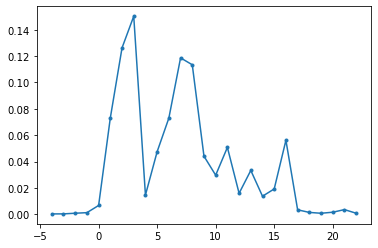

Expected points: 6.71


In [26]:
i=0
plt.plot(label_encoder.classes_, y_pred[i], '.-')
plt.show()
expected_points = np.matmul(label_encoder.classes_, y_pred[i])
print(f'Expected points: {np.round(expected_points,2)}')

In [28]:
expected_points = []
for i in range(0,y_pred.shape[0]):
    expectation = np.matmul(label_encoder.classes_, y_pred[i])
    expected_points.append(expectation)
np.array(expected_points)

array([6.71385263, 6.23170288, 5.23343949, 6.42642646, 6.07605951,
       5.5631905 , 4.58431532, 5.5716677 , 4.95805163, 6.19088902,
       5.71175348, 5.48602011, 5.6652926 , 5.89963555, 5.62379637,
       6.26421966, 6.15970066, 6.19727985, 5.69761848, 5.0283674 ,
       5.78313582, 6.1472506 , 6.60062887, 5.81623902, 5.70573423,
       5.83782508, 5.95649124, 6.09420425, 5.26133675, 5.70697439,
       5.98255717, 6.29085054, 5.49340972, 5.65831479, 6.08533299])

In [30]:
np.sum(expected_points)

203.70356474597065